In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import neural_tangents as nt
import flax.linen as nn

from neural_tangents import stax
from typing import Sequence
from jax import jit
from jax import random

from src.kernels.reference_kernels import ARDKernel, NeuralNetworkGaussianProcessKernel
from src.kernels.approximate_kernels import StochasticVariationalGaussianProcessKernel
from src.mean_functions.reference_mean_functions import ConstantFunction
from src.mean_functions.approximate_mean_functions import (
    StochasticVariationalGaussianProcessMeanFunction,
    NeuralNetworkMeanFunction,
)
from src.gaussian_measures.reference_gaussian_measures import ReferenceGaussianMeasure
from src.gaussian_measures.approximate_gaussian_measures import (
    ApproximateGaussianMeasure,
)

from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
from mnist import MNIST

mndata = MNIST("mnist_data")
mndata.gz = True
images, labels = mndata.load_training()
binary_class_labels = [0, 1, 2]
number_of_classes = len(binary_class_labels)

In [3]:
idx_labels_binary_class = [
    i for i in range(len(labels)) if labels[i] in binary_class_labels
]
binary_images = [images[idx] for idx in idx_labels_binary_class]
binary_labels = [labels[idx] for idx in idx_labels_binary_class]

In [4]:
import sklearn.preprocessing


def one_hot_encode(y, labels):
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(labels)
    return label_binarizer.transform(y)

In [5]:
number_of_inducing = 500
number_of_training_points = number_of_inducing
number_of_testing_points = 50

y = jnp.array(binary_labels)
y = one_hot_encode(y=y, labels=binary_class_labels)

x_inducing = jnp.array(binary_images[:number_of_inducing])
y_inducing = y[:number_of_inducing, :]

# x_train = jnp.array(binary_images[:number_of_training_points])
# y_train = y[:number_of_training_points, :]

# x_test = jnp.array(binary_images[number_of_training_points:number_of_training_points+number_of_testing_points])
# y_test = y[number_of_training_points:number_of_training_points+number_of_testing_points, :]

x_test = x_inducing[:number_of_testing_points, :]
y_test = y_inducing[:number_of_testing_points]

In [6]:
from src.classification_models import ReferenceClassificationModel
from src.parameters.classification_models import ReferenceClassificationModelParameters

In [7]:
ard_classification = ReferenceClassificationModel(
    gaussian_measures={
        label: ReferenceGaussianMeasure(
            x=x_inducing,
            y=y_inducing[:, i].reshape(-1),
            kernel=ARDKernel(number_of_dimensions=x_inducing.shape[1]),
            mean_function=ConstantFunction(),
        )
        for i, label in enumerate(binary_class_labels)
    }
)

In [8]:
ard_classification_parameters = ReferenceClassificationModelParameters(
    gaussian_measures={
        label: ard_classification.gaussian_measures[label].generate_parameters(
            {
                "log_observation_noise": jnp.log(2.0),
                "mean_function": {"constant": 0},
                "kernel": {
                    "log_scaling": jnp.log(1.0),
                    "log_lengthscales": 50 * jnp.ones(x_inducing.shape[1]).reshape(-1),
                },
            }
        )
        for label in binary_class_labels
    }
)

In [9]:
y_probabilities = ard_classification.predict_probability(
    parameters=ard_classification_parameters, x=x_test
)

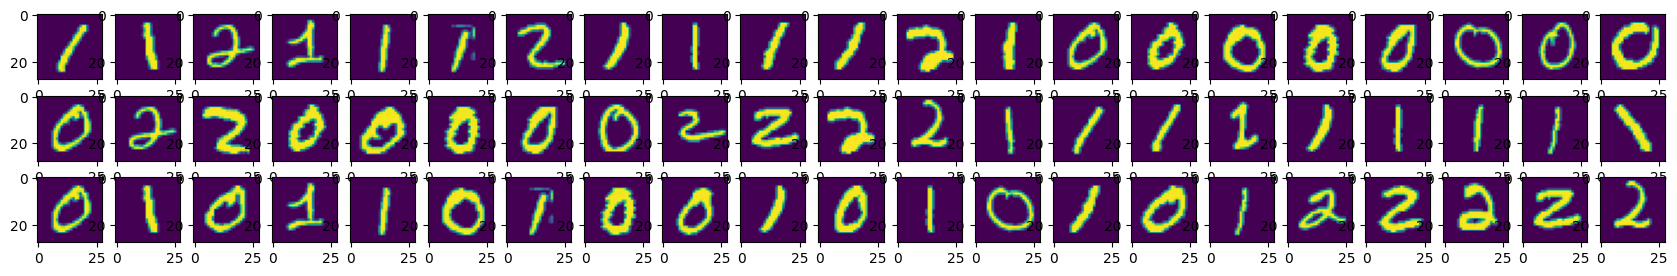

In [10]:
number_images_to_show = 21
idx_images_to_show = jnp.linspace(
    0, number_of_testing_points, number_images_to_show
).astype(int)
fig, ax = plt.subplots(
    number_of_classes,
    number_images_to_show,
    figsize=(number_images_to_show, number_of_classes),
)
for i in range(number_of_classes):
    argsort_idx = jnp.argsort(y_probabilities[:, i])
    for j, idx in enumerate(idx_images_to_show):
        ax[i, j].imshow(x_test[argsort_idx[idx], :].reshape(28, 28))